In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [29]:
import warnings
warnings.filterwarnings('ignore')
from tensorflow.python.keras.applications import DenseNet169, NASNetMobile


In [30]:
# model = ResNet50(include_top=True, weights=None, input_shape=(224, 224, 3), pooling=max, classes=7)
from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.python.keras.models import Model

backbone = NASNetMobile(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
backbone_out = backbone.output
gap = GlobalAveragePooling2D(name='pooling_layer')(backbone_out)
output = Dense(units=7, activation='softmax', name='output_layer')(gap)
chexnet_model = Model(inputs=backbone.input, outputs=output)

19996672/19993432 [==============================] - 2s 0us/step


In [4]:
# model.summary()

In [5]:
import pandas as pd

# data = pd.read_csv('./dataset.csv',index_col=0)
data = pd.read_csv('/home/ncp/workspace/data/dataset_.csv',index_col=0)

In [6]:
data.head(1)

,identifier,sex,age_group,age,height,weight,report,pneumonia_type,orginal_dcm_file,orginal_png_file,crop_file,body_part_file,diagnosis
0,H05_00019_02,M,A1,0개월,NaN,0.9,NaN,NaN,/home/ncp/workspace/data/train/04.신생아호흡곤란증후군/A...,/home/ncp/workspace/data/train/04.신생아호흡곤란증후군/A...,/home/ncp/workspace/data/crop/d4/H05_00019_02.png,/home/ncp/workspace/data/train/04.신생아호흡곤란증후군/A...,4


In [7]:
crop_list = list(data['crop_file'])

In [8]:
import cv2
import matplotlib.pyplot as plt

# plt.imshow(cv2.imread(crop_list[0]))
# print(cv2.imread(crop_list[0]).shape)

In [9]:
import numpy as np
import cv2

def cvt_crop(og_img_path, size):
    
    og_img = cv2.imread(og_img_path)
    
    
    # clahe
    clahe = cv2.createCLAHE(5.0,(20,20))
    
    ## og_img_convert
    cvt_img = cv2.resize(og_img, size)
    cvt_img = cv2.cvtColor(cvt_img,cv2.COLOR_BGR2GRAY)
    cvt_img = clahe.apply(cvt_img)  # 1 channel
    cvt_img = np.repeat(cvt_img[:,:,np.newaxis],3,-1)
    cvt_img = cvt_img

    return cvt_img
#     print(remove.shape)
#     plt.imshow(remove)

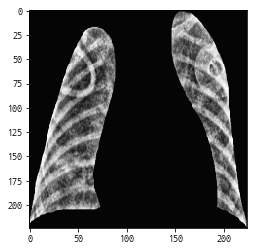

In [10]:
plt.imshow(cvt_crop(crop_list[0], (224,224)))

In [11]:
def normal_dia(x):
    if x == 9:
        return 0
    else:
        return x
    
    
data['diagnosis'] = data['diagnosis'].apply(normal_dia)

In [12]:
len(data)

4000

In [13]:
dcm_list = list(data['orginal_dcm_file'])
mask_path_list = list(data['body_part_file'])
img_path_list = []

for i in dcm_list:
    png_img = i.replace('.dcm','.png')
    img_path_list.append(png_img)

In [14]:
import numpy as np

def rv_3ch(og_img_path, mask_path, size):
    
    #module import
    import cv2
    
    # im_read
    og_img = cv2.imread(og_img_path)
    mask = cv2.imread(mask_path)
    
    # clahe
    clahe = cv2.createCLAHE(5.0,(8,8))
    
    ## og_img_convert
    cvt_img = cv2.resize(og_img, size)
    cvt_img = cv2.cvtColor(cvt_img,cv2.COLOR_BGR2GRAY)
    cvt_img = clahe.apply(cvt_img)  # 1 channel
    cvt_img = np.repeat(cvt_img[:,:,np.newaxis],3,-1)

    ## mask
    cvt_mask = cv2.resize(mask, size)
    cvt_mask = cv2.cvtColor(cvt_mask, cv2.COLOR_BGR2GRAY)

    ## remove
    remove = cv2.bitwise_and(cvt_img, cvt_img, mask = cvt_mask)
    
    return remove
#     print(remove.shape)
#     plt.imshow(remove)



In [15]:
X = np.ndarray((4000,224,224,3))

for i in range(len(X)):
#     X[i][:][:][:] = rv_3ch(img_path_list[i], mask_path_list[i], (224,224))
#       X[i][:][:][:] = cvt_crop(crop_list[i], (224,224))
    X[i][:][:][:] = cvt_crop(img_path_list[i], (224,224))
    
y = np.array(data['diagnosis'])

In [20]:
from sklearn.model_selection import train_test_split

Xtr, Xva, Ytr, Yva = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)
Xva, Xtst, Yva, Ytst = train_test_split(Xva,Yva, test_size=0.5, random_state=42, stratify=Yva)

In [21]:
from tensorflow.python.keras.utils import to_categorical

Ytr_c = to_categorical(Ytr)
Yva_c = to_categorical(Yva)
Ytst_c = to_categorical(Ytst)

In [22]:
print(Ytr.shape)
print(Yva.shape)
print(Ytst.shape)

(3200,)
(400,)
(400,)


In [23]:
pd.Series(list(Ytr)).value_counts()

5    800
0    800
4    512
6    387
1    327
3    275
2     99
dtype: int64

In [24]:
del X

In [25]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator


#data augmentation 

# Create two instances (images and targets) with the same arguments
data_gen_args = dict(zoom_range=0.1, horizontal_flip=True, vertical_flip = True, rotation_range = 10)
image_datagen = ImageDataGenerator(**data_gen_args)
# mask_datagen = ImageDataGenerator(**data_gen_args)
# ZeroDivisionError
seed = 1

train_generator = image_datagen.flow(x=Xtr, y=Ytr_c,
                                    batch_size=32,
                                    shuffle=True,
                                    )

validation_generator = image_datagen.flow(x=Xva, y=Yva_c,
                                         batch_size=32,
                                         shuffle=True)



In [31]:
from tensorflow.python.keras import backend as K
def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision

def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

class_weight = {0:0.571428563,
                1:1.397990367,
                2:4.617604545,
                3:1.662337636,
                4:0.892857129,
                5:0.571428563,
                6:1.181247674}

 
# class_weights = class_weight.compute_class_weight(
#                 'balanced',
#                  np.unique(train_generator.classes), 
#                  train_generator.classes)

chexnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision, recall, f1score])

In [ ]:
history = chexnet_model.fit_generator(train_generator, epochs=80 ,validation_data=validation_generator, class_weight=class_weight)

In [ ]:
history2= chexnet_model.fit(Xtr,Ytr_c, validation_data=[Xva, Yva_c], batch_size=32, epochs=50,verbose=1)

Train on 3200 samples, validate on 400 samples
Epoch 1/50
3200/3200 [==============================] - 282s 88ms/sample - loss: 1.4093 - acc: 0.4406 - precision: 0.5679 - recall: 0.2291 - f1score: 0.3149 - val_loss: 3.1394 - val_acc: 0.1575 - val_precision: 0.1492 - val_recall: 0.1322 - val_f1score: 0.1401
Epoch 2/50
3200/3200 [==============================] - 81s 25ms/sample - loss: 1.0307 - acc: 0.6156 - precision: 0.7158 - recall: 0.4694 - f1score: 0.5614 - val_loss: 3.2661 - val_acc: 0.2325 - val_precision: 0.2360 - val_recall: 0.2163 - val_f1score: 0.2256
Epoch 3/50
3200/3200 [==============================] - 72s 22ms/sample - loss: 0.7543 - acc: 0.7203 - precision: 0.7875 - recall: 0.6406 - f1score: 0.7041 - val_loss: 3.4938 - val_acc: 0.1225 - val_precision: 0.1283 - val_recall: 0.1226 - val_f1score: 0.1253
Epoch 4/50
3200/3200 [==============================] - 74s 23ms/sample - loss: 0.5505 - acc: 0.7978 - precision: 0.8365 - recall: 0.7547 - f1score: 0.7927 - val_loss: 2.13

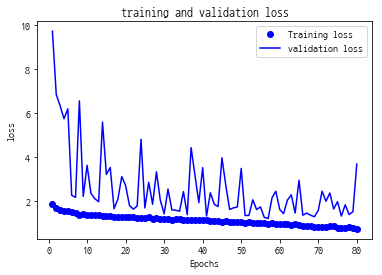

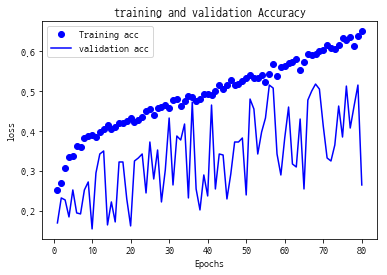

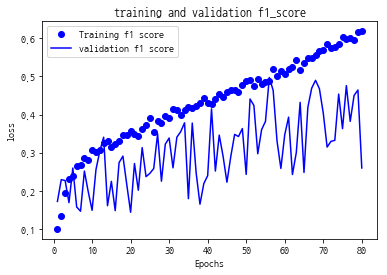

In [27]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.clf()

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'validation loss')
plt.title('training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.clf()
acc= history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label = 'validation acc')
plt.title('training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


plt.clf()
f1= history.history['f1score']
val_f1 = history.history['val_f1score']
plt.plot(epochs, f1, 'bo', label='Training f1 score')
plt.plot(epochs, val_f1, 'b', label = 'validation f1 score')
plt.title('training and validation f1_score')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [28]:
chexnet_model.evaluate(Xtst, Ytst_c)

400/400 [==============================] - 2s 6ms/sample - loss: 3.1077 - acc: 0.2825 - precision: 0.2990 - recall: 0.2644 - f1score: 0.2803


[3.107693119049072, 0.2825, 0.29896727, 0.26442307, 0.2803493]